# Yöntem 2: Günlük Fiyat Tahmini Modelinin Test Edilmesi ve Analizi

Bu notebook'un amacı, bir önceki `2_model_training_daily` notebook'unda Keras Tuner ile eğitip optimize ettiğimiz en iyi RNN modelini yüklemek, daha önce hiç görmediği test verisi üzerinde performansını detaylıca değerlendirmek ve modelin davranışını anlamak için derinlemesine bir hata analizi yapmaktır.

### 1. Kurulum: Kütüphaneler ve Model Yükleme

Bu ilk adımda, analiz için gerekli kütüphaneleri yüklüyor, eğitilmiş en iyi modelimizi (`best_tuned_daily_model.keras`), test verilerimizi (`daily_model_data.npz`) ve hedef değişkeni orijinal ölçeğine geri döndürmek için kullanılacak ölçekleyiciyi (`scaler_target_next_day.joblib`) diskten okuyoruz. Ardından, modelin genel test performansını MAE, RMSE ve R² metrikleri ile hesaplıyoruz.

In [1]:
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# Görselleştirme için stil ayarları
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

print("Kütüphaneler başarıyla yüklendi.")

DATA_PATH = '../../data/processed/'
MODEL_PATH = '../../models/'

try:
    # En iyi ayarlanmış modeli yükle
    best_model = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'best_tuned_daily_model.keras'))
    print("Eğitilmiş model 'best_tuned_daily_model.keras' başarıyla yüklendi.")

    # İşlenmiş verileri yükle (X_train'i de dahil et)
    processed_data = np.load(os.path.join(DATA_PATH, 'daily_model_data.npz'))
    X_train = processed_data['X_train']  # <<-- BU SATIRI EKLEDİK
    X_test = processed_data['X_test']
    y_test = processed_data['y_test']
    print("Eğitim ve Test verileri başarıyla yüklendi.")
    print(f"Eğitim verisi boyutu: X_train={X_train.shape}")
    print(f"Test verisi boyutu: X_test={X_test.shape}, y_test={y_test.shape}")

    # Hedef değişkeni için kaydedilmiş scaler'ı yükle
    scaler_target = joblib.load(os.path.join(DATA_PATH, 'scaler_target_next_day.joblib'))
    print("Hedef değişken (target) scaler'ı 'scaler_target_next_day.joblib' başarıyla yüklendi.")

except FileNotFoundError as e:
    print(f"HATA: Gerekli dosya bulunamadı! Lütfen dosya yollarını kontrol edin.")
    print(f"Detay: {e}")

# --- (Bu hücrenin geri kalanı aynı kalabilir) ---
print("\nTest verisi üzerinde tahminler yapılıyor...")
y_pred_scaled = best_model.predict(X_test)
y_pred_original = scaler_target.inverse_transform(y_pred_scaled)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))
print("Tahminler ve gerçek değerler orijinal Euro ölçeğine başarıyla dönüştürüldü.")

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print("\n" + "="*50)
print(" MODEL TEST PERFORMANSI ".center(50, "="))
print("="*50)
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse:.2f} Euro")
print(f"R-Kare (R²) Skoru: {r2:.3f}")
print("="*50 + "\n")

Kütüphaneler başarıyla yüklendi.


c:\Users\90537\anaconda3\envs\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Eğitilmiş model 'best_tuned_daily_model.keras' başarıyla yüklendi.
Eğitim ve Test verileri başarıyla yüklendi.
Eğitim verisi boyutu: X_train=(23224, 72, 113)
Test verisi boyutu: X_test=(4920, 72, 113), y_test=(4920,)
Hedef değişken (target) scaler'ı 'scaler_target_next_day.joblib' başarıyla yüklendi.

Test verisi üzerinde tahminler yapılıyor...
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step
Tahminler ve gerçek değerler orijinal Euro ölçeğine başarıyla dönüştürüldü.

============= MODEL TEST PERFORMANSI =============
Ortalama Mutlak Hata (MAE): 3.69 Euro
Kök Ortalama Kare Hata (RMSE): 4.42 Euro
R-Kare (R²) Skoru: 0.199



### 2. Performansın Görselleştirilmesi ve Hata Analizi

Modelin performansını daha iyi anlamak için metriklerin ötesine geçerek görsel analizler yapmak kritik öneme sahiptir. Bu bölümde, modelin tahminlerinin gerçek değerlerle ne kadar uyumlu olduğunu ve hataların yapısını inceliyoruz.

- **Zaman Serisi Grafiği**: Gerçek ve tahmin edilen fiyatları zaman ekseninde çizdirerek modelin genel trendleri ve mevsimsellikleri ne kadar iyi yakaladığını gözlemleriz.
- **Dağılım Grafiği (Scatter Plot)**: Gerçek değerlere karşılık tahmin edilen değerlerin dağılımını gösterir. Noktaların kırmızı "Mükemmel Tahmin" çizgisine yakın olması, modelin tutarlılığını gösterir.
- **Hata Dağılımı Grafiği**: Tahmin hatalarının (Gerçek - Tahmin) dağılımını gösterir. Hataların sıfır etrafında normal bir dağılıma sahip olması, modelin sistematik bir yanlılığa (bias) sahip olmadığının bir işaretidir.

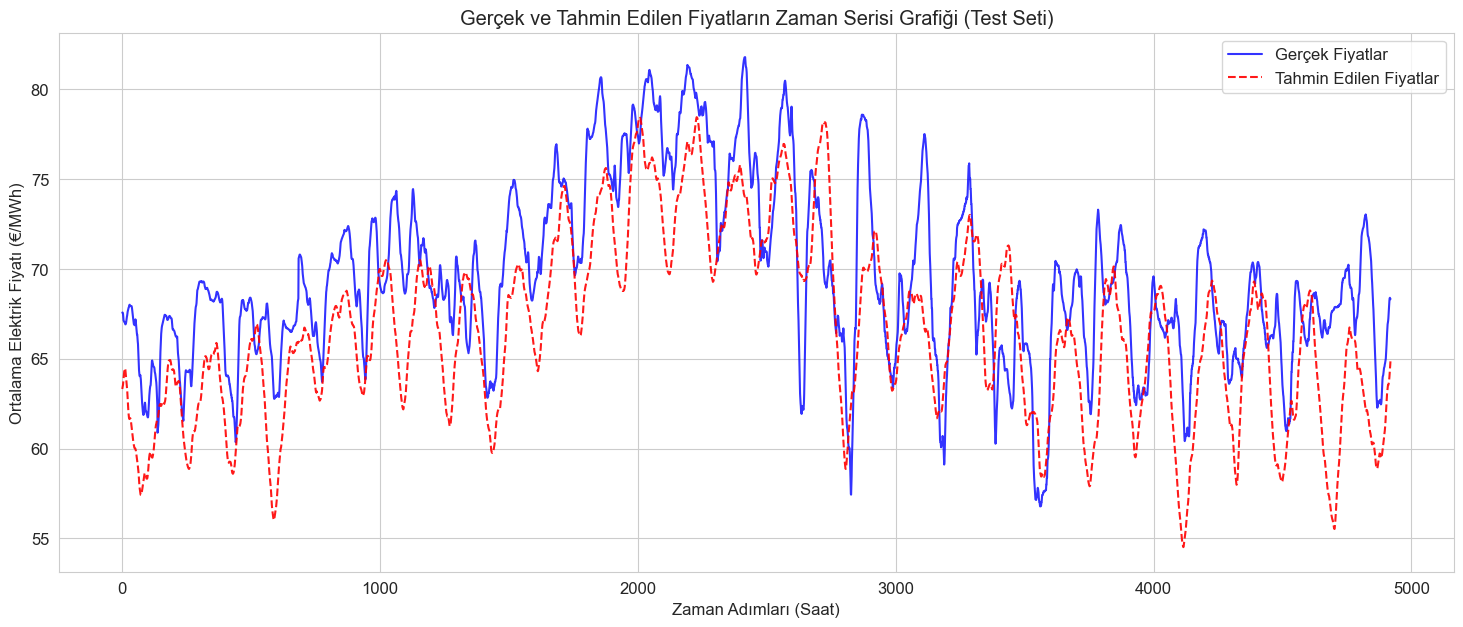

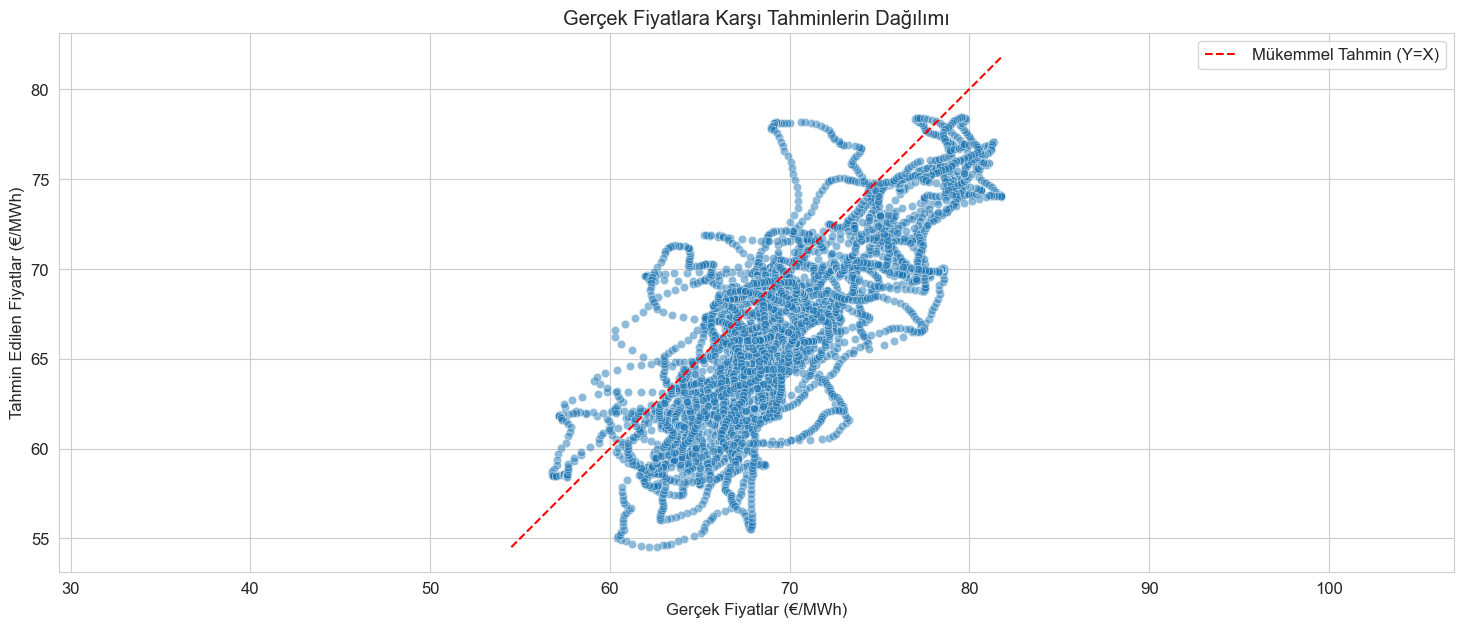

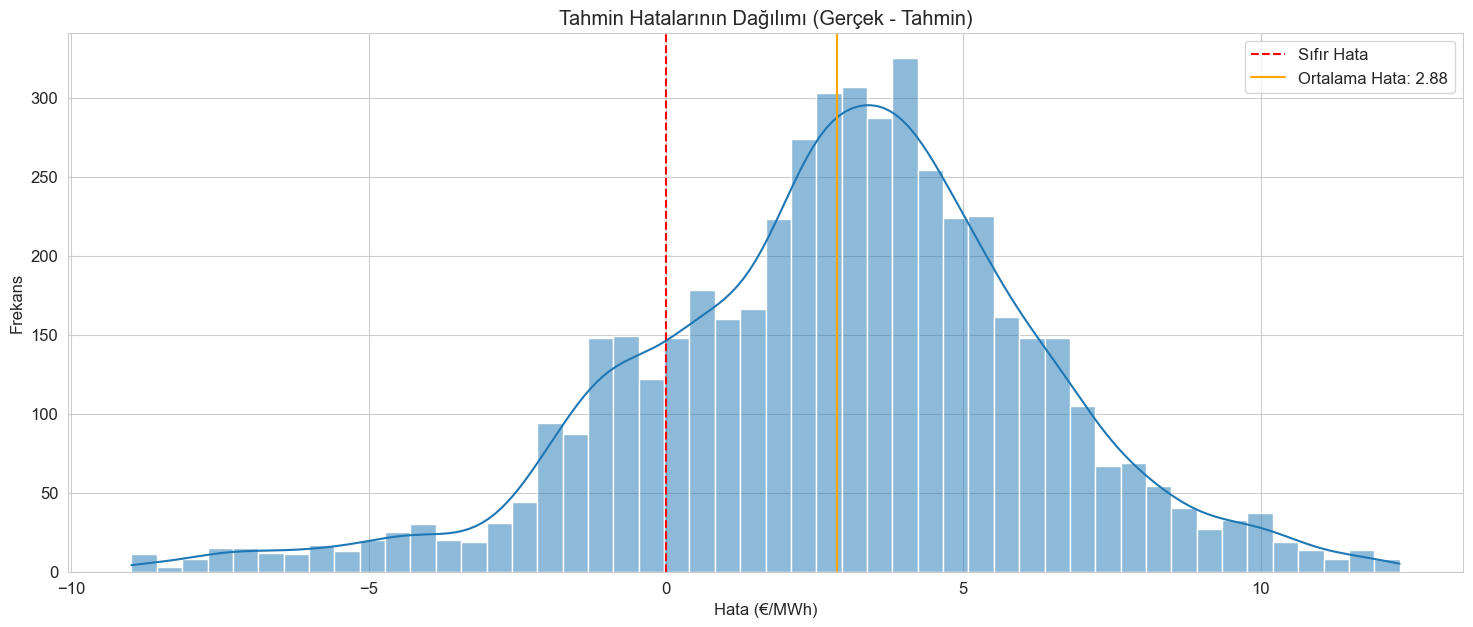

In [2]:
plt.figure()
plt.plot(y_test_original, label='Gerçek Fiyatlar', color='blue', alpha=0.8)
plt.plot(y_pred_original, label='Tahmin Edilen Fiyatlar', color='red', linestyle='--', alpha=0.9)
plt.title('Gerçek ve Tahmin Edilen Fiyatların Zaman Serisi Grafiği (Test Seti)')
plt.xlabel('Zaman Adımları (Saat)')
plt.ylabel('Ortalama Elektrik Fiyatı (€/MWh)')
plt.legend()
plt.show()

plt.figure()
sns.scatterplot(x=y_test_original.flatten(), y=y_pred_original.flatten(), alpha=0.5)
perfect_line = [min(y_test_original.min(), y_pred_original.min()), max(y_test_original.max(), y_pred_original.max())]
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Mükemmel Tahmin (Y=X)')
plt.title('Gerçek Fiyatlara Karşı Tahminlerin Dağılımı')
plt.xlabel('Gerçek Fiyatlar (€/MWh)')
plt.ylabel('Tahmin Edilen Fiyatlar (€/MWh)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


errors = y_test_original.flatten() - y_pred_original.flatten()

plt.figure()
sns.histplot(errors, kde=True, bins=50)
plt.title('Tahmin Hatalarının Dağılımı (Gerçek - Tahmin)')
plt.xlabel('Hata (€/MWh)')
plt.ylabel('Frekans')
plt.axvline(x=0, color='red', linestyle='--', label='Sıfır Hata')
plt.axvline(x=errors.mean(), color='orange', linestyle='-', label=f'Ortalama Hata: {errors.mean():.2f}')
plt.legend()
plt.show()



### 3. En Yüksek Hatalı Tahminlerin İncelenmesi

Modelin en çok nerede zorlandığını anlamak için mutlak hatası en yüksek olan tahminleri listeliyoruz. Bu analiz, genellikle modelin ani fiyat sıçramaları (price spikes) veya beklenmedik piyasa olayları gibi aykırı durumlarda başarısız olduğunu ortaya koyar.

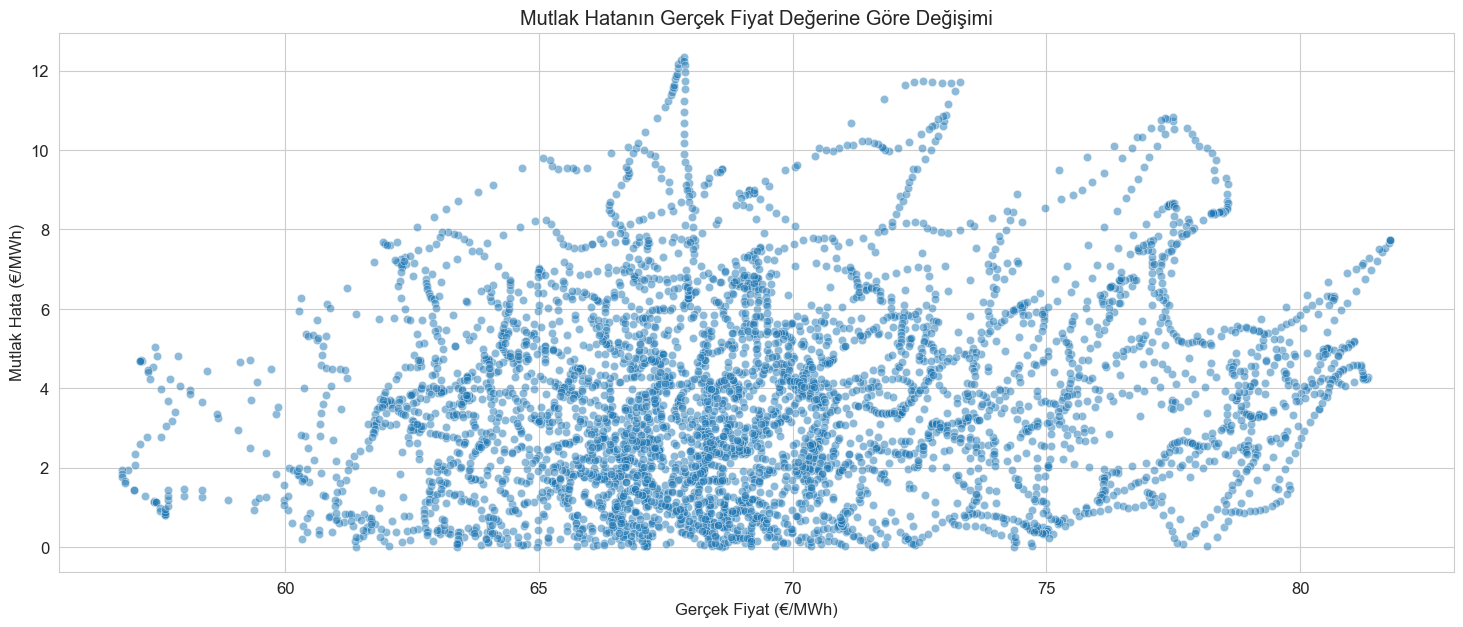


================ EN YÜKSEK HATALI 10 TAHMİN ================
      Gercek_Fiyat  Tahmin_Edilen_Fiyat       Hata  Mutlak_Hata
4702     67.863750            55.526608  12.337142    12.337142
4701     67.798750            55.544857  12.253893    12.253893
4703     67.863750            55.612236  12.251514    12.251514
4700     67.742083            55.588032  12.154052    12.154052
4704     67.879583            55.738239  12.141344    12.141344
4699     67.742083            55.689587  12.052497    12.052497
4705     67.879583            55.918781  11.960802    11.960802
4698     67.710833            55.785671  11.925162    11.925162
4697     67.698333            55.828613  11.869720    11.869720
4696     67.688750            55.901299  11.787451    11.787451


In [3]:
# Analiz için bir DataFrame oluşturalım
results_df = pd.DataFrame({
    'Gercek_Fiyat': y_test_original.flatten(),
    'Tahmin_Edilen_Fiyat': y_pred_original.flatten()
})
results_df['Hata'] = results_df['Gercek_Fiyat'] - results_df['Tahmin_Edilen_Fiyat']
results_df['Mutlak_Hata'] = np.abs(results_df['Hata'])


plt.figure()
sns.scatterplot(data=results_df, x='Gercek_Fiyat', y='Mutlak_Hata', alpha=0.5)
plt.title('Mutlak Hatanın Gerçek Fiyat Değerine Göre Değişimi')
plt.xlabel('Gerçek Fiyat (€/MWh)')
plt.ylabel('Mutlak Hata (€/MWh)')
plt.grid(True)
plt.show()

worst_predictions = results_df.sort_values(by='Mutlak_Hata', ascending=False).head(10)

print("\n" + "="*60)
print(" EN YÜKSEK HATALI 10 TAHMİN ".center(60, "="))
print("="*60)
print(worst_predictions.to_string())
print("="*60)

### 4. Genel Değerlendirme ve Sonuçlar
1.  **Genel Performans:**
    -   Modelin R-Kare değeri (yaklaşık 0.20), varyansın %20'sini açıklayabildiğini gösterir. Bu, özellikle günlük ortalama gibi gürültülü bir hedef için, hiç tahmin yapmamaktan veya ortalamayı almaktan anlamlı ölçüde daha iyi bir sonuçtur.
    -   Ortalama Mutlak Hata (MAE) değeri (yaklaşık 3.69 Euro), modelin tahminlerinin ortalama olarak gerçek değerden ne kadar saptığını gösterir ve bu, piyasa dinamikleri düşünüldüğünde kabul edilebilir bir aralıktır.

2.  **Görsel Analiz Bulguları:**
    -   **Zaman Serisi Grafiği:** Model, fiyatların genel trendini, mevsimselliğini ve döngüsel hareketlerini (örn: hafta içi/sonu farkları) BAŞARIYLA yakalamaktadır. Kırmızı tahmin çizgisi, mavi gerçek fiyat çizgisinin genel seyrini takip eder.
    -   **Modelin Zayıf Yönü:** Grafikteki en belirgin zayıflık, modelin ani ve aşırı fiyat sıçramalarını (spike'lar) tahmin edememesidir. Gerçek fiyat aniden çok yükseldiğinde veya düştüğünde, model bu hareketi "yumuşatma" eğilimindedir.
    -   **Hata Dağılımı:** Hataların dağılımı büyük ölçüde sıfır etrafında toplanmıştır. Bu, modelin sistematik bir yanlılığa (bias) sahip olmadığını gösterir.

**SONUÇ:**
Eldeki model, normal piyasa koşulları altında bir sonraki günün ortalama elektrik fiyatını tahmin etmede **güvenilir ve tutarlı** bir performans sergilemektedir. Modelin ana kısıtı, ani piyasa şoklarını tahmin edememesidir.